# Embeddings

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential

## Loading the data

In [2]:
with h5py.File('/data/joint_scoring/labels_test_regression.h5', 'r') as hf:
    y = hf['labels_test_regression'][:]
    
with h5py.File('/data/joint_scoring/img_test_regression.h5', 'r') as hf:
    imgs = hf['img_test_regression'][:]

imgs = imgs
y = y

y.shape, imgs.shape

((19709,), (19709, 150, 150, 1))

In [3]:
# images need to be rgb (shape (150, 150, 3))
from IPython.display import clear_output
from PIL import Image

imgs_rgb = []

for i, img in enumerate(imgs):
    if i % 1000 == 0:
        clear_output()
        print("Converting train images to RGB, {0:.2f} % finished".format(i/72298*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    imgs_rgb.append(dat)

Converting train images to RGB, 26.28 % finished


In [4]:
imgs_rgb = np.array(imgs_rgb)

In [5]:
from tensorflow.python.keras.applications.inception_v3 import preprocess_input

imgs_rgb = [preprocess_input(x) for x in imgs_rgb.astype("float32")]

In [6]:
imgs = np.array(imgs_rgb)

In [7]:
from tensorflow.python.keras import backend as K

def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = K.square(diff)
    loss = K.mean(diff_2)
    return loss

In [8]:
from tensorflow.python.keras.models import load_model

loaded_model = load_model("/data/joint_scoring/models/20171128_000703.h5", custom_objects={"crps":crps})

In [9]:
p = loaded_model.predict(imgs)

In [10]:
pred = np.zeros(p.shape[0])

for i in range(p.shape[0]):
    pred[i] = sum(1 - p[i])

In [11]:
diff = pred - y

In [12]:
diff

array([ 0.01009613,  0.01126152,  0.00702405, ...,  0.01014924,
        0.01024306,  0.03865761])

## Build truncated model

In [13]:
loaded_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 74, 74, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 74, 74, 32)    96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 74, 74, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [14]:
from tensorflow.python.keras.models import Model
layer_name = 'activation_96'
model = Model(inputs=loaded_model.input, 
              outputs=loaded_model.get_layer(layer_name).output)

## Get embeddings

In [15]:
embeddings = model.predict(imgs)

In [16]:
from sklearn.decomposition import PCA
x_50d = PCA(n_components=50).fit_transform(embeddings)

In [17]:
from sklearn.manifold import TSNE
x_2d = TSNE(n_components=2, random_state=1).fit_transform(x_50d)

## 2D

In [18]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, cmap=plt.cm.get_cmap("viridis"))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_regression.png', bbox_inches='tight')

In [19]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=diff, cmap=plt.cm.get_cmap("RdBu"))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_diference_regression.png', bbox_inches='tight')

## KNN

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [21]:
weights = {0: 0.07078770511377204, 65: 64.043209876543216, 35: 19.320297951582869, 100: 4.3665824915824913, 5: 0.29950059178430183, 70: 21.614583333333332, 40: 7.3738450604122248, 10: 0.63830441737418486, 75: 138.33333333333334, 45: 30.336257309941519, 15: 2.5133236434108528, 80: 22.456709956709958, 50: 10.90956887486856, 20: 2.087105210219272, 85: 111.55913978494624, 55: 58.61581920903955, 25: 8.3534621578099841, 90: 27.666666666666668, 60: 14.653954802259888, 30: 5.45478443743428, 95: 384.25925925925924}
print(weights)

{0: 0.07078770511377204, 65: 64.04320987654322, 35: 19.32029795158287, 100: 4.366582491582491, 5: 0.29950059178430183, 70: 21.614583333333332, 40: 7.373845060412225, 10: 0.6383044173741849, 75: 138.33333333333334, 45: 30.33625730994152, 15: 2.513323643410853, 80: 22.456709956709958, 50: 10.90956887486856, 20: 2.087105210219272, 85: 111.55913978494624, 55: 58.61581920903955, 25: 8.353462157809984, 90: 27.666666666666668, 60: 14.653954802259888, 30: 5.45478443743428, 95: 384.25925925925924}


In [22]:
def weight(x):
    return np.vectorize(x.astype("int"))

In [32]:
cv_scores = []

kk = range(1,200,10)

for k in kk:
    print(k)
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, embeddings, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191


In [33]:
mse = [-1 * x for x in cv_scores]
mse

[140.36596844602064,
 80.798579808064346,
 77.650522127929932,
 76.231974520080939,
 76.362127387919685,
 76.268369791376372,
 76.035875676057657,
 76.046582816532407,
 76.021786227862563,
 75.973053135000967,
 76.061131177392824,
 76.209725679986974,
 76.330282447266399,
 76.369382714954355,
 76.4316832858418,
 76.510082116051819,
 76.606608861315095,
 76.813117970090403,
 76.953669423646431,
 77.110429278689054]

The optimal number of neighbors is 91


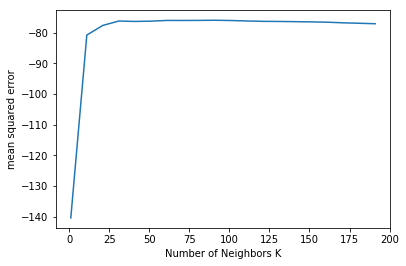

In [34]:
# determining best k
from matplotlib import pyplot as plt
optimal_k = kk[mse.index(min(mse))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.close()
plt.plot(kk, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('mean squared error')
plt.show()

In [23]:
from sklearn.model_selection import cross_val_predict
knn = KNeighborsRegressor(n_neighbors=91)
pred = cross_val_predict(estimator=knn, X=embeddings, y=y, cv=10)

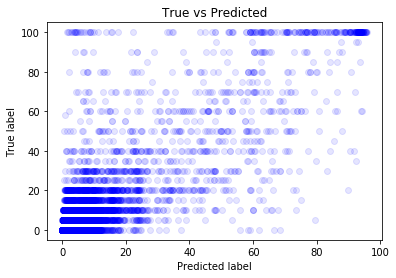

In [29]:
plt.close()

plt.title("True vs Predicted")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.scatter(x=pred, y=y, color="blue", alpha=0.1)

plt.show()

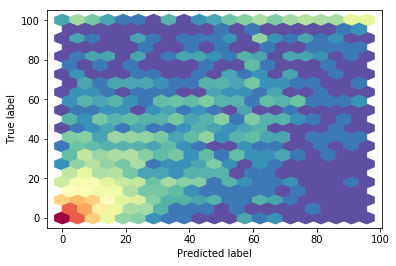

In [30]:
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.hexbin(x=pred, y=y, gridsize=20, bins='log', cmap=plt.cm.Spectral_r)

plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
mean_absolute_error(y_true=y, y_pred=pred)

3.6951406703804084

In [33]:
mean_squared_error(y_true=y, y_pred=pred)

66.184355681530221

In [34]:
r2_score(y_true=y, y_pred=pred)

0.6841641064775692

## 3D

In [19]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=3, random_state=1).fit_transform(x_50d)

In [20]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure(figsize=(25,25))
ax = Axes3D(fig)
ax.scatter(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], c=y, cmap=plt.cm.get_cmap("viridis"))
plt.savefig('/data/joint_scoring/images/tsne_3d_regression.png', bbox_inches='tight')

In [21]:
!pip3 install scikit-image --upgrade
from skimage.transform import resize
imgs_resized = [resize(image=x, output_shape=(50, 50)) for x in imgs]
imgs_resized = np.array(imgs_resized)

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.5/dist-packages
Requirement already up-to-date: matplotlib>=1.3.1 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: PyWavelets>=0.4.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: six>=1.7.3 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: pillow>=2.1.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: scipy>=0.17.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: networkx>=1.8 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: numpy>=1.7.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1.3.1->scikit-image)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
n_colors = len(np.unique(y.astype("int16")))

In [23]:
cm = plt.cm.get_cmap("viridis", n_colors)
color = np.ones((n_colors, 4))
for i in range(n_colors):
    color[i] = cm(1.*i/n_colors)

color = [np.append((x[0:-1] * 255),1) for x in color]
color = np.array(color)


color = color.astype("int16")

print(color)
print(type(color[0]))

[[ 68   1  84   1]
 [ 71  18 101   1]
 [ 72  34 115   1]
 [ 70  49 126   1]
 [ 66  64 133   1]
 [ 60  77 138   1]
 [ 54  91 140   1]
 [ 48 103 141   1]
 [ 43 115 142   1]
 [ 39 126 142   1]
 [ 34 137 141   1]
 [ 31 150 139   1]
 [ 31 161 135   1]
 [ 38 172 129   1]
 [ 53 183 120   1]
 [ 53 183 120   1]
 [100 203  93   1]
 [129 211  76   1]
 [159 217  56   1]
 [191 223  36   1]
 [223 227  24   1]
 [253 231  36   1]]
<class 'numpy.ndarray'>


In [33]:
y_unique = np.unique(y.astype("int16"))
y_unique = y_unique.tolist()
print(y_unique)
y_index = y_unique.index(50)
print(y_index)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 58, 60, 65, 70, 75, 80, 85, 90, 95, 100]
10


In [34]:
from PIL import Image
from PIL import ImageMath
from IPython.display import clear_output

imgs_border = []

old_size = (50, 50)
new_size = (54, 54)

y_unique = np.unique(y.astype("int16"))
y_unique = y_unique.tolist()

for i, img in enumerate(imgs_resized):
    if i % 100 == 0:
        clear_output()
        print("Creating images with colored borders, {0:.2f} % finished".format(i/19611*100))
    old_im = Image.fromarray((img.squeeze()*255).astype("int16"))
    old_im = old_im.convert("RGB")
    y_index = y_unique.index(y[i])
    new_im = Image.new("RGB", new_size, tuple(color[int(y_index)]))
    new_im.paste(old_im, (2,2))
    dat = np.asarray(a=new_im)
    imgs_border.append(dat)

Creating images with colored borders, 100.45 % finished


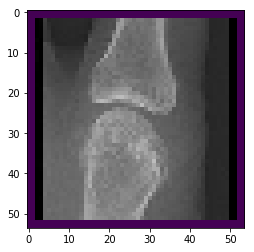

In [39]:
plt.imshow(imgs_border[0])
plt.show()

In [40]:

res = 8000 # resolution of plot
cval = 255 # background colour

images = imgs_border
max_width = max([image.shape[0] for image in images])
max_height = max([image.shape[1] for image in images])

In [41]:
f2d = x_2d

xx = f2d[:, 0]
yy = f2d[:, 1]
x_min, x_max = xx.min(), xx.max()
y_min, y_max = yy.min(), yy.max()
# Fix the ratios
sx = (x_max-x_min)
sy = (y_max-y_min)
if sx > sy:
    res_x = sx/float(sy)*res
    res_y = res
else:
    res_x = res
    res_y = sy/float(sx)*res

In [42]:
res_x, res_y

(8000, 8377.4373466625111)

In [43]:
res_y=res_y.astype("int16")

In [44]:
images[0].shape

(54, 54, 3)

In [45]:
canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
x_coords = np.linspace(x_min, x_max, res_x)
y_coords = np.linspace(y_min, y_max, res_y)
i = 0
for x, y, image in zip(xx, yy, images):
    clear_output()
    print("Creating plot, {0:.2f} % finished".format(i/19611*100))
    i = i + 1
    w, h = image.shape[:2]
    x_idx = np.argmin((x - x_coords)**2)
    y_idx = np.argmin((y - y_coords)**2)
    canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image

In [46]:
plt.figure(figsize=(400,400))
plt.imshow(canvas)
plt.savefig('/data/joint_scoring/images/embeddings_regression.png', bbox_inches='tight')